# Cora dataset

In [1]:
# import torch_geometric datasets
try:
    from torch_geometric.datasets import Planetoid
except:
    !pip install -q torch-geometric
    from torch_geometric.datasets import Planetoid

# get Cora dataset
dataset = Planetoid(root='.', name='Cora')

# get data
data = dataset[0]

# print information about the dataset
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes} \n")

# print information about the graph
print(f"Edges are directed? {data.is_directed()}")
print(f"Graph has isolated nodes? {data.has_isolated_nodes()}")
print(f"Graph has self loop? {data.has_self_loops()}")

Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7 

Edges are directed? False
Graph has isolated nodes? False
Graph has self loop? False


In [2]:
# read the Cora dataset into pandas DataFrame
import pandas as pd

# read dataset into DataFrame
df = pd.DataFrame(data.x)

# add label
df['label'] = pd.DataFrame(data.y)

# print information
print(f"Shape of the DataFrame: {df.shape}")
df.head()

Shape of the DataFrame: (2708, 1434)


,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


# Node classification with node features but without graph topology

In [3]:
import torch_geometric
import torch
from tqdm.auto import tqdm

# setup training step function
def train_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               data: torch_geometric.data.data.Data,
              adjacency: torch.Tensor):

    # switch to training mode
    model.train()
    
    # forward pass
    if adjacency is not None:
        out = model(data.x, adjacency)
    else:
        out = model(data.x)
    
    # training loss
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    
    # training accuracy
    train_acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
    
    # zero out gradient
    optimizer.zero_grad()
    
    # back propagation
    loss.backward()
    
    # optimizer step
    optimizer.step()

    return loss.item(), train_acc
    

# setup test step function
def test_step(model: torch.nn.Module,
              data: torch_geometric.data.data.Data,
              adjacency: torch.Tensor,
             loss_fn: torch.nn.Module):
    
    # switch to evaluation mode
    model.eval()
    # turn on torch inference mode
    with torch.inference_mode():
        # test forward pass
        if adjacency is not None:
            out = model(data.x, adjacency)
        else:
            out = model(data.x)
        # test loss
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask])
        
        # test accuracy
        test_acc = accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask]).item()
        
    # test accuracy
    return test_loss, test_acc

# setup train function
def train(model: torch.nn.Module,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         data: torch_geometric.data.data.Data,
          adjacency: torch.Tensor,
         epochs: int=100):

    results = {
        'train_loss': [],
        'train_acc' : [],
        'test_loss' : [],
        'test_acc'  : []
    }
    
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data=data,
            adjacency=adjacency
        )

        test_loss, test_acc = test_step(
            model=model,
            loss_fn=loss_fn,
            data=data,
            adjacency=adjacency
        )

        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)
        results['train_acc'].append(train_acc)
        results['test_acc'].append(test_acc)
        
    return results

In [4]:
# setup accuracy metric
def accuracy(y_pred, y_true):
    return torch.sum(y_pred==y_true) / len(y_pred)

In [5]:
import torch
from torch import nn, functional

# setup multilayer perceptron class
class MLP(torch.nn.Module):
    def __init__(self, dim_in: int, dim_h: int, dim_out: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features=dim_in, out_features=dim_h),
            nn.ReLU(),
            nn.Linear(in_features=dim_h, out_features=dim_out)
        )
    def forward(self, x: torch.Tensor):
        return nn.functional.log_softmax(self.block(x), dim=1)

In [6]:
# create an MLP instance
mlp = MLP(dim_in=dataset.num_features, dim_h=16, dim_out=dataset.num_classes)

In [7]:
# setup loss function and optimizer for MLP
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=1e-2, weight_decay=5e-4)

In [8]:
# training
results = train(
    model=mlp,
    loss_fn=loss_fn,
    optimizer=optimizer,
    data=data,
    adjacency=None,
    epochs=300
)

  0%|          | 0/300 [00:00<?, ?it/s]

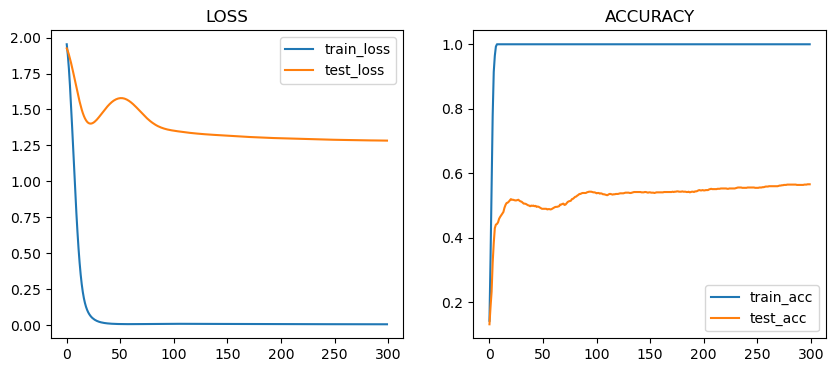

In [9]:
# visualize training and testing loss and accuracy
from typing import Dict
import matplotlib.pyplot as plt

def visualize_results(results: Dict):
    # train and test loss
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(results['train_loss'], label='train_loss')
    ax[0].plot(results['test_loss'], label='test_loss')
    ax[0].set_title("LOSS")
    ax[0].legend()
    
    ax[1].plot(results['train_acc'], label='train_acc')
    ax[1].plot(results['test_acc'], label='test_acc')
    ax[1].set_title("ACCURACY")
    ax[1].legend()

visualize_results(results)

# Node classification using Node features and graph Topology

In [10]:
# setup adjacency matrix
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [11]:
# setup vanilla layer
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [12]:
# setup vanilla gnn
class VanillaGNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return torch.nn.functional.log_softmax(h, dim=1)


In [13]:
# create a vanilla gnn instance
van = VanillaGNN(
    dim_in=dataset.num_features,
    dim_h=16,
    dim_out=dataset.num_classes
)

In [14]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=van.parameters(), lr=1e-2, weight_decay=5e-4)

In [15]:
# training
results = train(
    model=van,
    loss_fn=loss_fn,
    optimizer=optimizer,
    data=data,
    adjacency=adjacency,
    epochs=300
)

  0%|          | 0/300 [00:00<?, ?it/s]

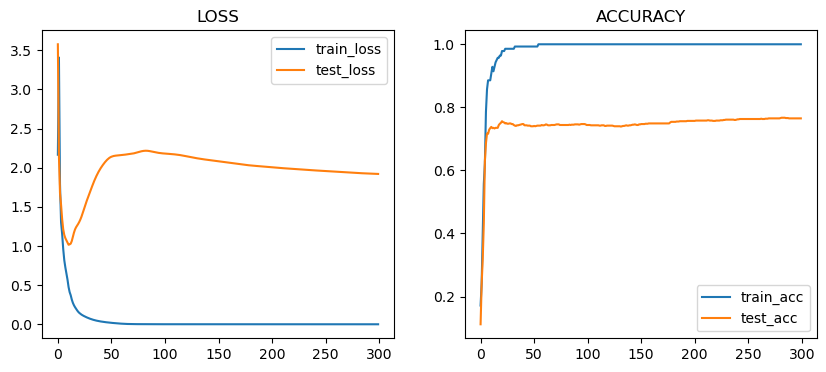

In [16]:
# visualize vanillagnn training results
visualize_results(results)